<a href="https://colab.research.google.com/github/ManDes71/Rakuten_Text_Classification_ML/blob/main/notebooks/Exploration_Rakuten_langues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Google Colab -> Cette cellule est à executer (1 fois) pour le cloner le dépot en local**  

In [1]:
!git clone https://github.com/ManDes71/Rakuten_Text_Classification_ML.git

Cloning into 'Rakuten_Text_Classification_ML'...
remote: Enumerating objects: 536, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 536 (delta 37), reused 18 (delta 11), pack-reused 468
Receiving objects: 100% (536/536), 64.56 MiB | 12.22 MiB/s, done.
Resolving deltas: 100% (266/266), done.
Updating files: 100% (78/78), done.
Filtering content: 100% (5/5), 1.41 GiB | 39.24 MiB/s, done.


**Google Colab -> Cette cellule est à executer (2 fois) pour installer les bibliothèques nécessaires**  
You must restart the runtime in order to use newly installed versions.

In [1]:
import sys
sys.path.append('/content/Rakuten_Text_Classification_ML')
!pip install -r /content/Rakuten_Text_Classification_ML/requirements.txt

In [2]:
import numpy as np
print(np.__version__)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_colwidth', 100)

1.26.3


In [3]:
# lecture des données sources d'entrainement
df_feats=pd.read_csv('/content/Rakuten_Text_Classification_ML/input/X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv('/content/Rakuten_Text_Classification_ML/input/Y_train_CVw08PX.csv')

# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)


nomenclature=pd.read_csv('/content/Rakuten_Text_Classification_ML/input/NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
 5   prdtypecode  84916 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 4.5+ MB
None


La bibliothèquee **detectlang** va être utilisée pour détecter la langue des libellés dans le but d'y appliquer ensuite un filtre de **stopwords** propre à chaque langue.  
Il faut rejeter certaines lignes car incompatible avec le module detectlang.  
On ecarte les descriptions ne comportant que des chiffres
ou contenant  soit "https://" , soit  "http://"

In [4]:
df_descrip=df.dropna(subset=['description'])
list_rejet=[]
df_descrip.info()
r2=re.compile("https?://")
r=re.compile("[a-zA-Z]")
for i in df_descrip.index :
    pointeur=r.findall(df_descrip.loc[i,'description']) # il y a des lettres alphabétiques dans la description
    pointeur2=r2.findall(df_descrip.loc[i,'description']) # contient "https://" ou "http://"
    if pointeur == []:
        print(str(df_descrip.loc[i,'description'])+'\n')
        list_rejet.append(df_descrip.loc[i,'Id'])  # il n'y a pas de lettres alphabétiques
    else:
        if len(pointeur2) > 0 :
            if len(df_descrip.loc[i,'description']) <120:
                print(str(df_descrip.loc[i,'description'])+'\n')
                list_rejet.append(df_descrip.loc[i,'Id'])  # contient "https://" ou "http://"



#### descriptions : on  passe les description sans lettres et contenant "https://" ou "http://" en NAN

for i in list_rejet:
    df.loc[i,'description']=np.NaN
print(df.info())
print(len(list_rejet))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55116 entries, 2 to 84914
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           55116 non-null  int64 
 1   designation  55116 non-null  object
 2   description  55116 non-null  object
 3   productid    55116 non-null  int64 
 4   imageid      55116 non-null  int64 
 5   prdtypecode  55116 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.9+ MB
1989

...

...

-

0

1985

...

2259.00

1984

https://placehold.it/100x70

https://www.pro-bems.com/IMAGES/images_1/FIGJJCT0000117/m/FIGJJCT0000117_5.jpg

-

...

...

19.236-7

.

...

(1

-

0

-

1999 1/220

...

1985

-

-

1972.

(1

0

...

1980

-

https://www.pro-bems.com/IMAGES/images_1/FIG83X17001/m/FIG83X17001_5.jpg

(1

-

-

...

0

-

1985

-

...

https://www.pro-bems.com/IMAGES/images/BOOKPNLIGMAG19/m/BOOKPNLIGMAG19_5.jpg

1969

.

0

-

...

0

3323

-

1988

1947

1986

...

-

1991

-

ht

#### la colonne description passe de 55116 à 55049 lignes

In [5]:
df2=df.copy()

-----------------------------------------------------
#                         ***GENERERATION DF_LANGUE.CSV***
 -----------------------------------------------------

Cette partie sert à générer un fichier qui va contenir pour chaque produit les langue prédites pour chacuns des libellés (désignation,description) et leurs probabilités de certitude.  
Cette partie peut être relativement longue,  
si le fichier a déjà été généré ,il est possible de se rendre directement au paragraphe suivant  
=>  EXPLORATION


##**Recherche de la langue sur df_feats['designation'**]¶

Recherche de la langue sur df_feats['designation']  
La fonction detect_langs renvoie une liste d'objets, chacun représentant une langue possible avec une probabilité associée.  
Ces probabilités sont normalisées de manière à ce que leur somme soit égale à 1.

In [6]:
from langdetect import detect_langs

print(df['designation'].head())
result=detect_langs(str(df['designation'].head()))
print("Langue possible sur l'ensemble des 5 premières lignes")
print(len(result),result)


0               Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design
1    Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris -...
2                           Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style
3                                        Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt)
4                                                                                   La Guerre Des Tuques
Name: designation, dtype: object
Langue possible sur l'ensemble des 5 premières lignes
3 [en:0.7142628898014072, de:0.14287843748440546, fr:0.1428586233177094]


création de 3 colonnes :  
df[**'langue'**]   objet langue  majoritaire renvoyée par le module detect_langs  
 df[**'pays_design'**]  langue la plus probable pour le champ 'designation'  
df[**'Ratio_design'**]   probabilite de la langue majoritaire renvoyée par le module detect_langs

In [7]:

df['langue']=df['designation'].apply( lambda x : str(detect_langs(str(x))[0])[0:7] )
df['pays_design']=df['langue'].apply( lambda x : str(x)[0:2] )
df['Ratio_design']=df['langue'].apply( lambda x : str(x)[3:] ).astype(float)
df.head()

,Id,designation,description,productid,imageid,prdtypecode,langue,pays_design,Ratio_design
0,0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,10,de:0.99,de,0.99
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris -...,NaN,436067568,1008141237,2280,fr:0.99,fr,0.99
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<...,201115110,938777978,50,en:0.40,en,0.40
3,3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496,1280,de:0.85,de,0.85
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'a...,278535884,1077757786,2705,ca:0.57,ca,0.57


## **Recherche de la langue sur df_feats['description**']

In [8]:
df_descrip=df.dropna(subset=['description'])
print(df_descrip['description'].head())
result=detect_langs(str(df_descrip['description'].head()))
print(len(result),result)


2     PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<...
4     Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'a...
7     CONQUERANT CLASSIQUE Cahier 240 x 320 mm seyès incolorecouverture en Polypro 96 pages agrafé pap...
9     Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m50.Que vous soyez un particulier pour votre jardin ...
10    The timeless DSW seat can now be paired with more types of legs! These wood legs look like a nat...
Name: description, dtype: object
1 [fr:0.9999958627492083]


création de 2 colonnes :  
df[**'langue_descr'**] objet langue  majoritaire renvoyé par le module detect_langs  
df[**'descrip_long'**] taille du champ 'description'

In [9]:
df_descrip['langue_descr']=df_descrip['description'].apply( lambda x : str(detect_langs(str(x))[0])[0:7] )
df_descrip['descrip_long'] = df_descrip['description'].apply(lambda x : len(x))
df3=df_descrip[['Id','langue_descr','descrip_long']]
df=pd.merge(df,df3,on='Id',how='outer')
print(df.info())
df.head()

<ipython-input-9-9d5ff210bf53>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_descrip['langue_descr']=df_descrip['description'].apply( lambda x : str(detect_langs(str(x))[0])[0:7] )
<ipython-input-9-9d5ff210bf53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_descrip['descrip_long'] = df_descrip['description'].apply(lambda x : len(x))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            84916 non-null  int64  
 1   designation   84916 non-null  object 
 2   description   55049 non-null  object 
 3   productid     84916 non-null  int64  
 4   imageid       84916 non-null  int64  
 5   prdtypecode   84916 non-null  int64  
 6   langue        84916 non-null  object 
 7   pays_design   84916 non-null  object 
 8   Ratio_design  84916 non-null  float64
 9   langue_descr  55049 non-null  object 
 10  descrip_long  55049 non-null  float64
dtypes: float64(2), int64(4), object(5)
memory usage: 7.8+ MB
None


,Id,designation,description,productid,imageid,prdtypecode,langue,pays_design,Ratio_design,langue_descr,descrip_long
0,0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,10,de:0.99,de,0.99,NaN,NaN
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris -...,NaN,436067568,1008141237,2280,fr:0.99,fr,0.99,NaN,NaN
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<...,201115110,938777978,50,en:0.40,en,0.40,fr:0.99,760.0
3,3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496,1280,de:0.85,de,0.85,NaN,NaN
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'a...,278535884,1077757786,2705,ca:0.57,ca,0.57,fr:0.99,213.0


création de 2 colonnes :  
df[**'pays_descr**']  langue la plus probable pour le champ 'description'  
df[**'Ratio_descr'**]   probabilite de la langue majoritaire renvoyé par le module detect_langs  

In [10]:
df['pays_descr']=df[~df['langue_descr'].isna() ]['langue_descr'].apply( lambda x : str(x)[0:2] )
df['Ratio_descr']=df[~df['langue_descr'].isna() ]['langue_descr'].apply( lambda x : str(x)[3:] ).astype('float')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            84916 non-null  int64  
 1   designation   84916 non-null  object 
 2   description   55049 non-null  object 
 3   productid     84916 non-null  int64  
 4   imageid       84916 non-null  int64  
 5   prdtypecode   84916 non-null  int64  
 6   langue        84916 non-null  object 
 7   pays_design   84916 non-null  object 
 8   Ratio_design  84916 non-null  float64
 9   langue_descr  55049 non-null  object 
 10  descrip_long  55049 non-null  float64
 11  pays_descr    55049 non-null  object 
 12  Ratio_descr   55049 non-null  float64
dtypes: float64(3), int64(4), object(6)
memory usage: 9.1+ MB
None


,Id,designation,description,productid,imageid,prdtypecode,langue,pays_design,Ratio_design,langue_descr,descrip_long,pays_descr,Ratio_descr
0,0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,10,de:0.99,de,0.99,NaN,NaN,NaN,NaN
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris -...,NaN,436067568,1008141237,2280,fr:0.99,fr,0.99,NaN,NaN,NaN,NaN
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<...,201115110,938777978,50,en:0.40,en,0.40,fr:0.99,760.0,fr,0.99
3,3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496,1280,de:0.85,de,0.85,NaN,NaN,NaN,NaN
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'a...,278535884,1077757786,2705,ca:0.57,ca,0.57,fr:0.99,213.0,fr,0.99


## **algorythme de la determination de la langue**

In [11]:
def determination_langue(dtframe):
    if dtframe['Ratio_design']>0.98 :
        ReponseLang = dtframe['pays_design']
    else:
        if dtframe['Ratio_descr']>0.98 :
            ReponseLang = dtframe['pays_descr']
        else:
            ReponseLang = dtframe['pays_design']
    return ReponseLang;
def determination_ratio(dtframe):
    if dtframe['Ratio_design']>0.98 :
        ReponseLang = dtframe['Ratio_design']
    else:
        if dtframe['Ratio_descr']>0.98 :
            ReponseLang = dtframe['Ratio_descr']
        else:
            ReponseLang = dtframe['Ratio_design']
    return ReponseLang;
def determination_origine(dtframe):
    if dtframe['Ratio_design']>0.98 :
        ReponseLang = "Designation"
    else:
        if dtframe['Ratio_descr']>0.98 :
            ReponseLang = "Description"
        else:
            ReponseLang = "Designation"
    return ReponseLang;

In [12]:
df['PAYS_LANGUE']=df.apply( determination_langue,axis=1)
df['RATIO_LANGUE']=df.apply( determination_ratio,axis=1)
df['ORIGINE_LANGUE']=df.apply( determination_origine,axis=1)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              84916 non-null  int64  
 1   designation     84916 non-null  object 
 2   description     55049 non-null  object 
 3   productid       84916 non-null  int64  
 4   imageid         84916 non-null  int64  
 5   prdtypecode     84916 non-null  int64  
 6   langue          84916 non-null  object 
 7   pays_design     84916 non-null  object 
 8   Ratio_design    84916 non-null  float64
 9   langue_descr    55049 non-null  object 
 10  descrip_long    55049 non-null  float64
 11  pays_descr      55049 non-null  object 
 12  Ratio_descr     55049 non-null  float64
 13  PAYS_LANGUE     84916 non-null  object 
 14  RATIO_LANGUE    84916 non-null  float64
 15  ORIGINE_LANGUE  84916 non-null  object 
dtypes: float64(4), int64(4), object(8)
memory usage: 11.0+ MB
None


,Id,designation,description,productid,imageid,prdtypecode,langue,pays_design,Ratio_design,langue_descr,descrip_long,pays_descr,Ratio_descr,PAYS_LANGUE,RATIO_LANGUE,ORIGINE_LANGUE
0,0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,10,de:0.99,de,0.99,NaN,NaN,NaN,NaN,de,0.99,Designation
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris -...,NaN,436067568,1008141237,2280,fr:0.99,fr,0.99,NaN,NaN,NaN,NaN,fr,0.99,Designation
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<...,201115110,938777978,50,en:0.40,en,0.40,fr:0.99,760.0,fr,0.99,fr,0.99,Description
3,3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496,1280,de:0.85,de,0.85,NaN,NaN,NaN,NaN,de,0.85,Designation
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'a...,278535884,1077757786,2705,ca:0.57,ca,0.57,fr:0.99,213.0,fr,0.99,fr,0.99,Description


##  **sauvegarde de 'df_langue.csv**'

In [13]:
df_langue=df[['Id','prdtypecode','PAYS_LANGUE','RATIO_LANGUE','ORIGINE_LANGUE','pays_design','Ratio_design','pays_descr','Ratio_descr']].copy()
df_langue['design_long'] = df['designation'].apply(lambda x : len(x)).copy()
df_langue['descrip_long'] = df['descrip_long'].copy()
df_langue['descr_NaN'] = df['description'].isna().copy()
df_langue.to_csv('/content/Rakuten_Text_Classification_ML/src/df_langue.csv')
df_langue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              84916 non-null  int64  
 1   prdtypecode     84916 non-null  int64  
 2   PAYS_LANGUE     84916 non-null  object 
 3   RATIO_LANGUE    84916 non-null  float64
 4   ORIGINE_LANGUE  84916 non-null  object 
 5   pays_design     84916 non-null  object 
 6   Ratio_design    84916 non-null  float64
 7   pays_descr      55049 non-null  object 
 8   Ratio_descr     55049 non-null  float64
 9   design_long     84916 non-null  int64  
 10  descrip_long    55049 non-null  float64
 11  descr_NaN       84916 non-null  bool   
dtypes: bool(1), float64(4), int64(3), object(4)
memory usage: 7.9+ MB


#             **EXPLORATION**

## **récupération du fichier df_langue.csv**

In [14]:
df_langue=pd.read_csv('/content/Rakuten_Text_Classification_ML/src/df_langue.csv')
print(df_langue.info())
df=df2.merge(df_langue.drop(['Unnamed: 0','prdtypecode'], axis=1),on='Id',how='inner')
df['status'] = df['descr_NaN'].apply(lambda x: 'SansDescrip' if x else 'AvecDescrip').astype(str)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      84916 non-null  int64  
 1   Id              84916 non-null  int64  
 2   prdtypecode     84916 non-null  int64  
 3   PAYS_LANGUE     84916 non-null  object 
 4   RATIO_LANGUE    84916 non-null  float64
 5   ORIGINE_LANGUE  84916 non-null  object 
 6   pays_design     84916 non-null  object 
 7   Ratio_design    84916 non-null  float64
 8   pays_descr      55049 non-null  object 
 9   Ratio_descr     55049 non-null  float64
 10  design_long     84916 non-null  int64  
 11  descrip_long    55049 non-null  float64
 12  descr_NaN       84916 non-null  bool   
dtypes: bool(1), float64(4), int64(4), object(4)
memory usage: 7.9+ MB
None


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              84916 non-null  int64  
 1   designation     84916 non-null  object 
 2   description     55049 non-null  object 
 3   productid       84916 non-null  int64  
 4   imageid         84916 non-null  int64  
 5   prdtypecode     84916 non-null  int64  
 6   PAYS_LANGUE     84916 non-null  object 
 7   RATIO_LANGUE    84916 non-null  float64
 8   ORIGINE_LANGUE  84916 non-null  object 
 9   pays_design     84916 non-null  object 
 10  Ratio_design    84916 non-null  float64
 11  pays_descr      55049 non-null  object 
 12  Ratio_descr     55049 non-null  float64
 13  design_long     84916 non-null  int64  
 14  descrip_long    55049 non-null  float64
 15  descr_NaN       84916 non-null  bool   
 16  status          84916 non-null  object 
dtypes: bool(1), float64(4), int64(5

## **Désignation**

**Répartition des langues pour la colonne 'designation'**

Index(['fr', 'en', 'de', 'nl', 'ca', 'it', 'ro', 'pt', 'es', 'id'], dtype='object')


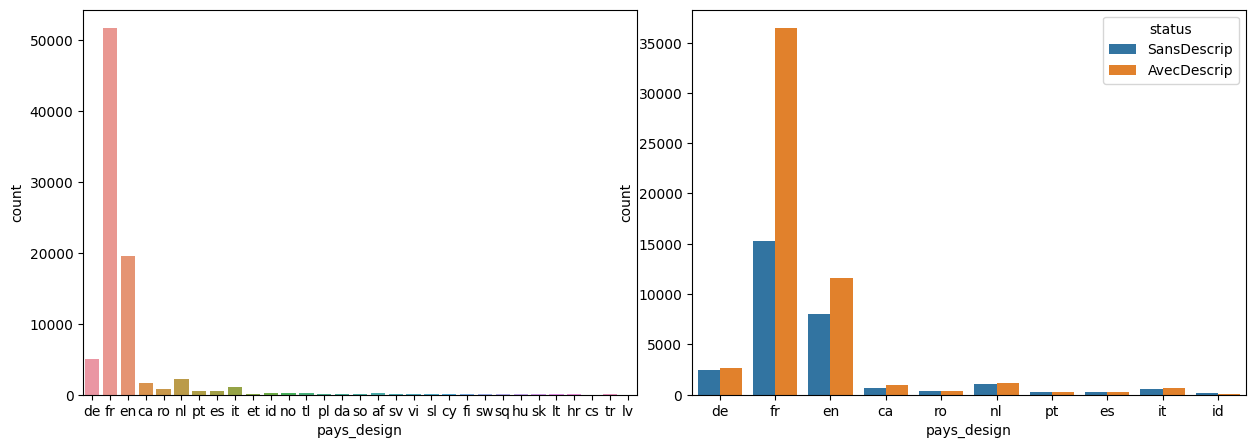

In [15]:

fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.countplot(x=df['pays_design'],ax=axs[0])
pays_principaux=df['pays_design'].value_counts()[:10]
print(pays_principaux.index)
sns.countplot(x=df[df['pays_design'].isin(pays_principaux.index)]['pays_design'],hue=df['status'],ax=axs[1])
plt.subplots_adjust( wspace=0.1,hspace=0.5)
plt.show()

In [16]:
print("Le francais et l'anglais sont les langues majoritaires !")
print("1/3 des produits n'ont pas de descriptions")
df['status'].value_counts()

Le francais et l'anglais sont les langues majoritaires !
1/3 des produits n'ont pas de descriptions


AvecDescrip    55049
SansDescrip    29867
Name: status, dtype: int64

**Répartition des langues pour la colonne 'designation'  avec ratio_langue   = 0.99 (déterminée avec certitude)**

Index(['fr', 'en', 'de', 'nl', 'ca', 'it', 'ro', 'pt', 'es', 'id'], dtype='object')


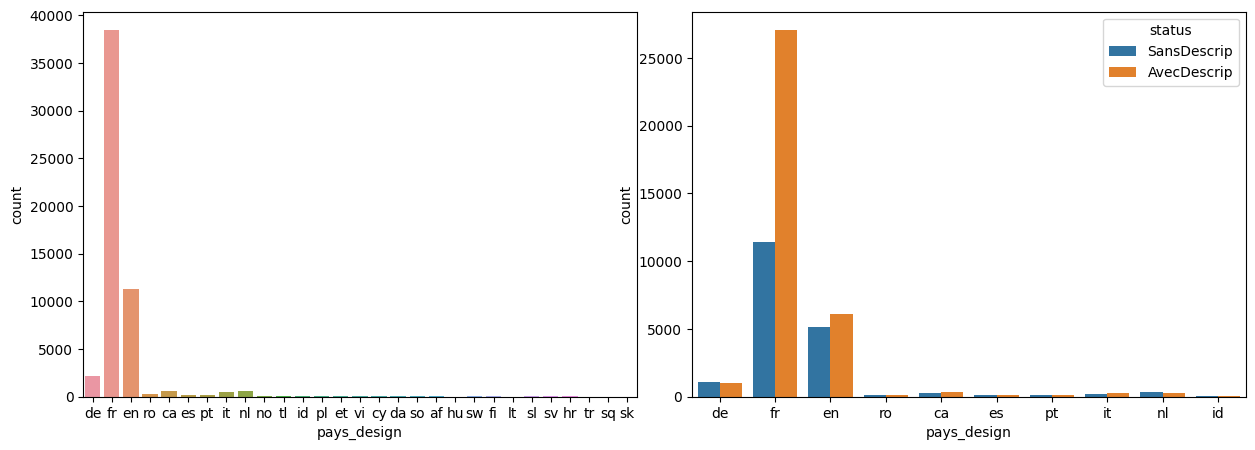

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
df_99=df[df['Ratio_design']>0.98]
#df_99.info()
sns.countplot(x=df_99['pays_design'],ax=axs[0])
pays_principaux99=df['pays_design'].value_counts()[:10]
print(pays_principaux99.index)
sns.countplot(x=df_99[df_99['pays_design'].isin(pays_principaux99.index)]['pays_design'],hue=df['status'],ax=axs[1])
plt.subplots_adjust( wspace=0.1,hspace=0.5)
plt.show()

**désignations : longueurs des libellés**

250


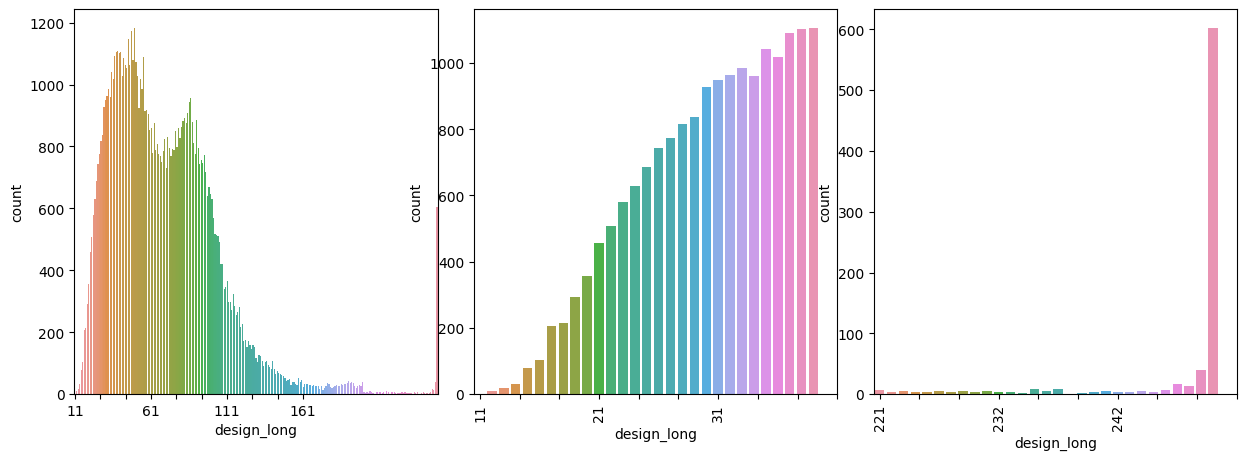

In [18]:
print(df_langue['design_long'].max())
fig, axs = plt.subplots(1, 3, figsize=(15,5))

sns.countplot(x=df_langue['design_long'],ax=axs[0])
axs[0].set_xticks(np.linspace(0,150, 10))
sns.countplot(x=df_langue[df_langue['design_long'] <40]['design_long'],ax=axs[1])
axs[1].set_xticks(np.linspace(0, 30, 10))
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
sns.countplot(x=df_langue[(df_langue['design_long'] > 220) & (df_langue['design_long'] < 300)]['design_long'],ax=axs[2])
axs[2].set_xticks(np.linspace(0, 30, 10))
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)
plt.subplots_adjust( wspace=0.1,hspace=0.5)
plt.show()

## **Description**

**Répartition des langues pour la colonne 'description'**

Index(['fr', 'en', 'de', 'ca', 'it', 'cy', 'pt', 'ro', 'es', 'vi'], dtype='object')


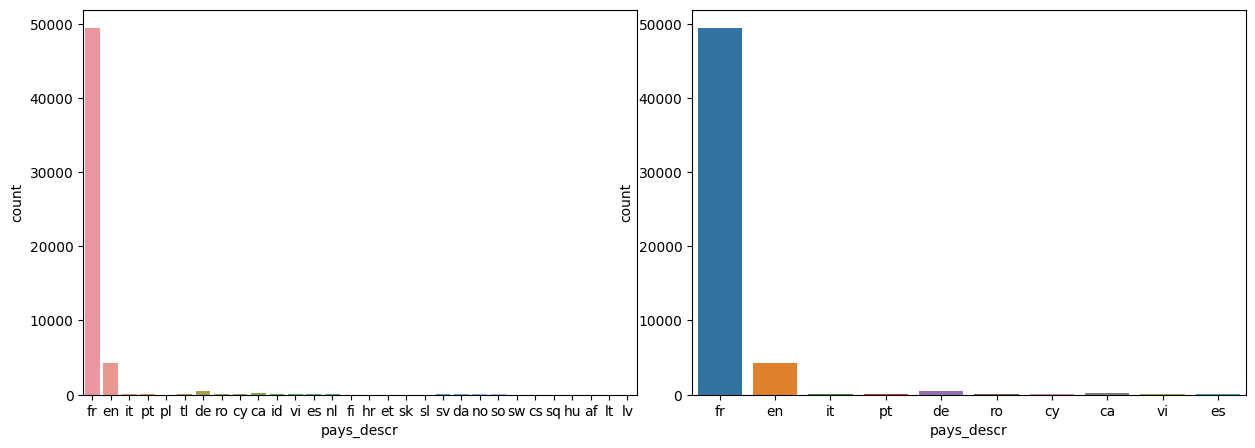

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
df_descrip=df.dropna(subset=['description'])
sns.countplot(x=df_descrip['pays_descr'],ax=axs[0])
pays_principaux=df['pays_descr'].value_counts()[:10]
print(pays_principaux.index)
plt.subplots_adjust( wspace=0.1,hspace=0.5)
sns.countplot(x=df[df['pays_descr'].isin(pays_principaux.index)]['pays_descr'],ax=axs[1])
plt.subplots_adjust( wspace=0.1,hspace=0.5)
plt.show()

In [20]:
print("Le francais et l'anglais sont les langues majoritaires !")


Le francais et l'anglais sont les langues majoritaires !


12451.0


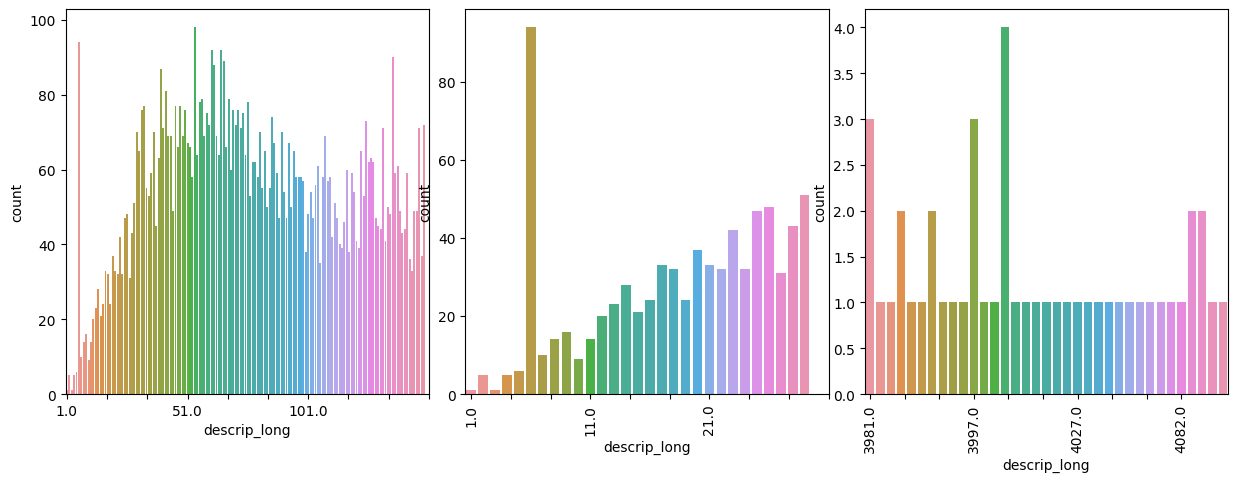

In [21]:
print(df_langue['descrip_long'].max())
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.countplot(x=df_langue[(df_langue['descrip_long']  < 150) ]['descrip_long'],ax=axs[0])
#xmin, xmax = axs[0].get_xlim()
axs[0].set_xticks(np.linspace(0, 150, 10))
sns.countplot(x=df_langue[ (df_langue['descrip_long'] <30)]['descrip_long'],ax=axs[1])
axs[1].set_xticks(np.linspace(0, 30, 10))
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
sns.countplot(x=df_langue[(df_langue['descrip_long'] > 3980) & (df_langue['descrip_long'] < 4100)]['descrip_long'],ax=axs[2])
axs[2].set_xticks(np.linspace(0, 30, 10))
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)
plt.subplots_adjust( wspace=0.1,hspace=0.5)
plt.show()

**création d'un dataframe rassemblant les 8 langues les plus représentatives de chaque catégorie et en rassemblant les autres sous la dénomination "XX"**

In [22]:
df2=df.copy()
for prt in df2['prdtypecode'].unique():
    print("prdtypecode : " ,prt)
    filtre = df2['prdtypecode']==prt
    pays_principaux=df2[filtre]['PAYS_LANGUE'].value_counts()[:8]
    print(pays_principaux.index)
    df2.loc[(filtre) & (~df2['PAYS_LANGUE'].isin(pays_principaux.index)),'PAYS_LANGUE']="XX"

prdtypecode :  10
Index(['fr', 'en', 'de', 'nl', 'es', 'it', 'ca', 'pt'], dtype='object')
prdtypecode :  2280
Index(['fr', 'en', 'de', 'nl', 'it', 'ca', 'ro', 'es'], dtype='object')
prdtypecode :  50
Index(['fr', 'en', 'de', 'nl', 'no', 'pt', 'ro', 'ca'], dtype='object')
prdtypecode :  1280
Index(['fr', 'en', 'de', 'nl', 'it', 'ca', 'ro', 'es'], dtype='object')
prdtypecode :  2705
Index(['fr', 'en', 'de', 'nl', 'ca', 'it', 'es', 'ro'], dtype='object')
prdtypecode :  2522
Index(['fr', 'en', 'de', 'nl', 'ca', 'it', 'pt', 'ro'], dtype='object')
prdtypecode :  2582
Index(['fr', 'en', 'de', 'ca', 'nl', 'ro', 'pt', 'es'], dtype='object')
prdtypecode :  1560
Index(['fr', 'en', 'de', 'ca', 'nl', 'pt', 'it', 'no'], dtype='object')
prdtypecode :  1281
Index(['fr', 'en', 'de', 'nl', 'es', 'it', 'ca', 'id'], dtype='object')
prdtypecode :  1920
Index(['fr', 'en', 'de', 'nl', 'ca', 'ro', 'it', 'no'], dtype='object')
prdtypecode :  2403
Index(['fr', 'en', 'nl', 'de', 'ca', 'it', 'es', 'ro'], dtype='o

## **Répartition des langues par catégorie (XX = le reste du monde)**

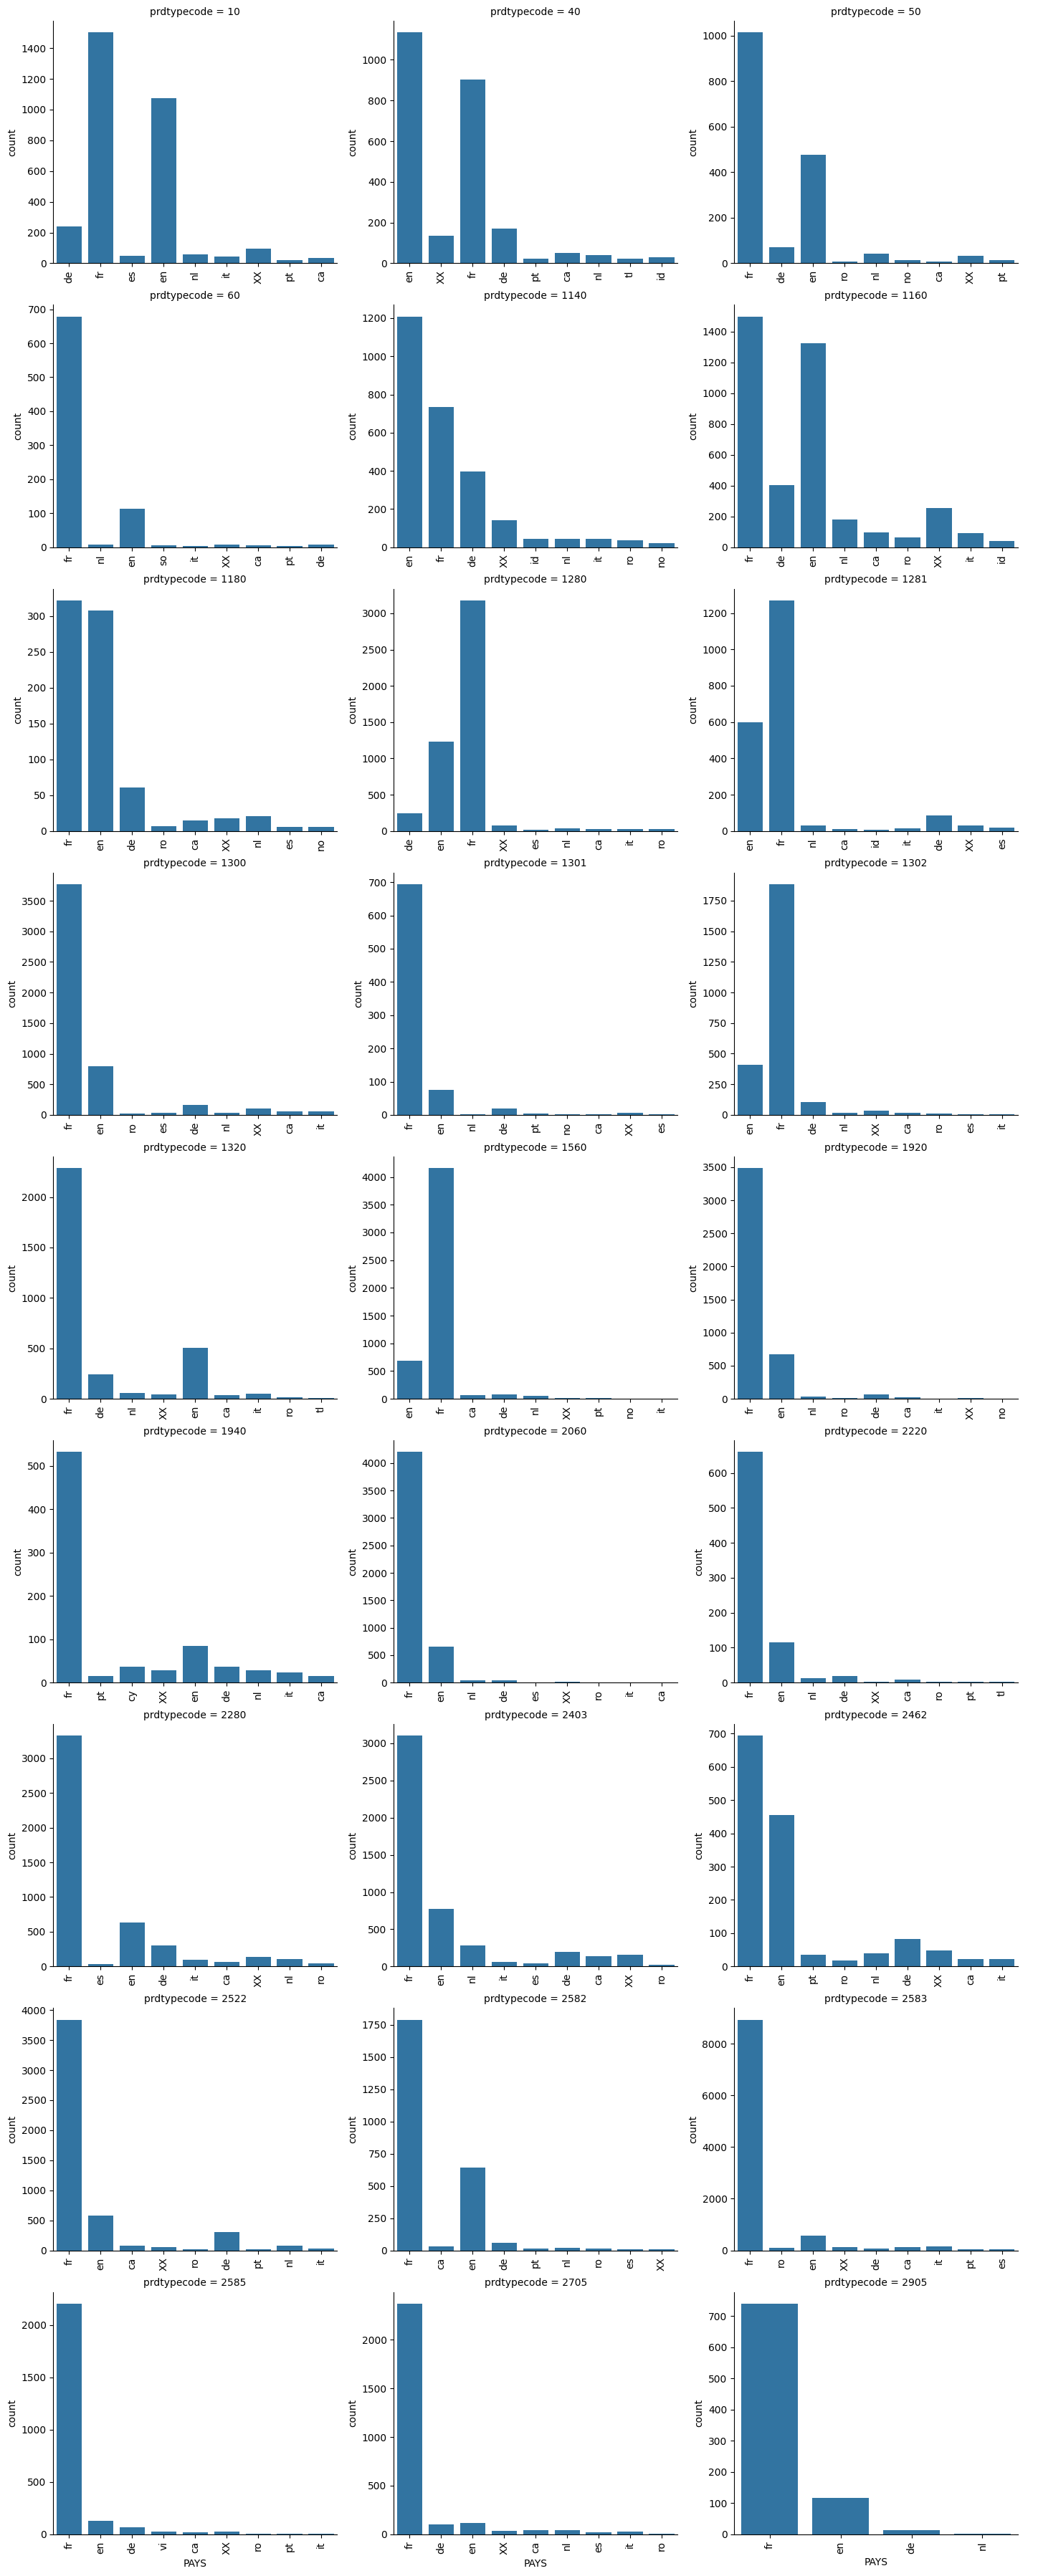

In [23]:
g = sns.FacetGrid(data=df2, col='prdtypecode', col_wrap=3,sharex=False, sharey=False, height=4, aspect=1.2)
g.map_dataframe(sns.countplot, 'PAYS_LANGUE')
g.set_xticklabels( rotation=90)
g.set_xlabels('PAYS')
g.add_legend()
plt.show()


## Niveau de certitude (de 0 à 1) sur la determination de
## la langue principale par catégorie   

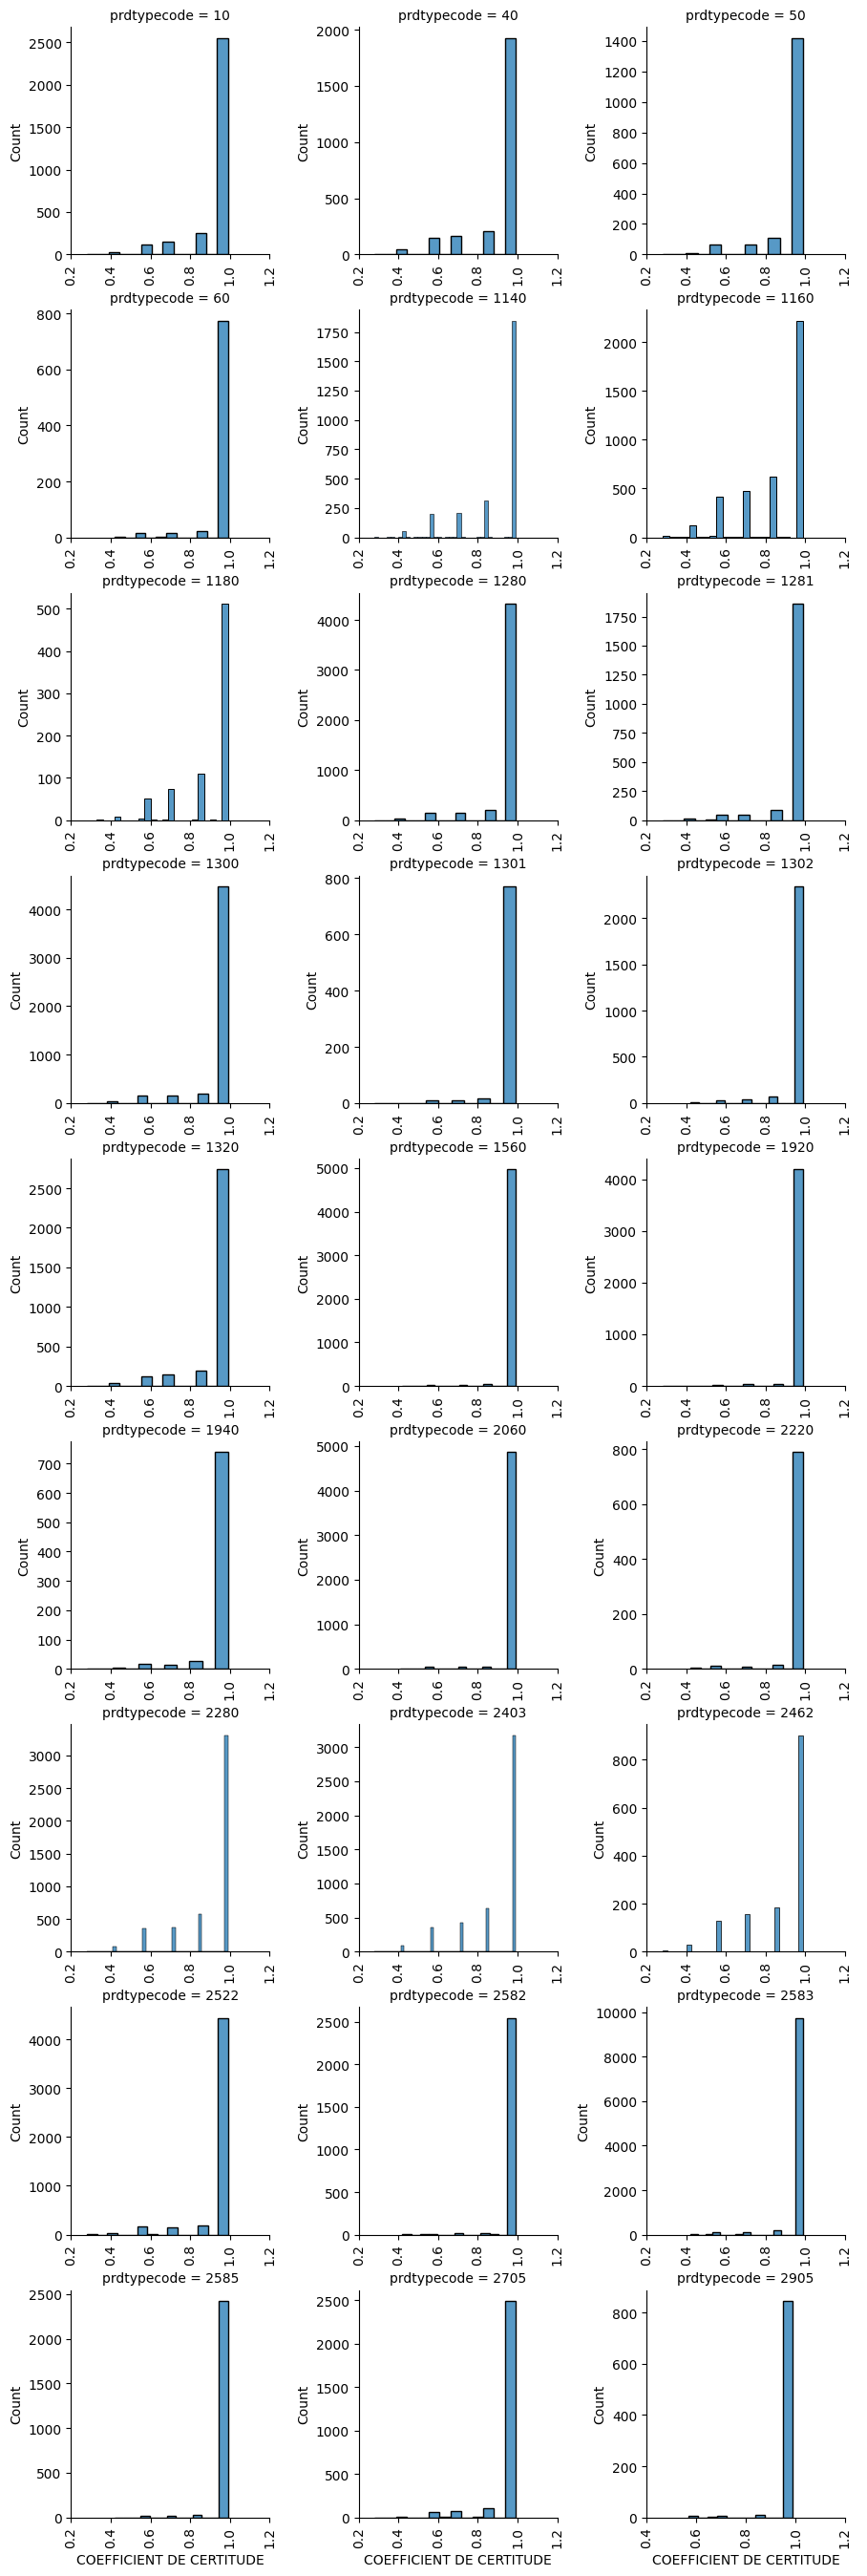

In [24]:
g = sns.FacetGrid(data=df2, col='prdtypecode', col_wrap=3,sharex=False, sharey=False)
g.map_dataframe(sns.histplot, 'RATIO_LANGUE')
g.set_xticklabels( rotation=90)
g.set_xlabels('COEFFICIENT DE CERTITUDE')
g.add_legend()
plt.show()

## critère déterminant du choix de la langue

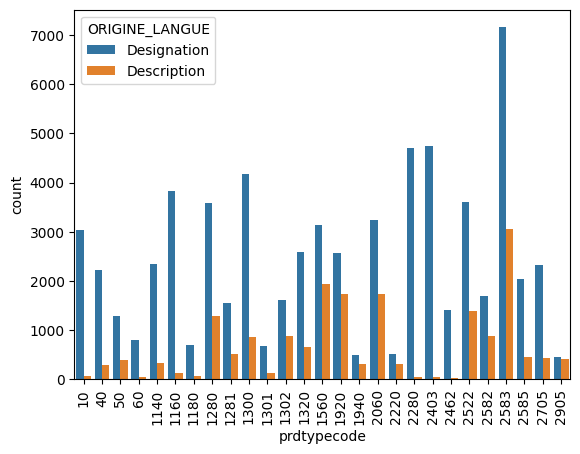

In [25]:

g=sns.countplot(x=df['prdtypecode'],hue=df['ORIGINE_LANGUE'])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()